In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import wrds
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

#db.create_pgpass_file()


c:\Users\Yass La Menace\anaconda3\envs\Coding\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_11748\2012917318.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df=pd.read_csv('C:\EPFL\master\elec\MA2\Investments\investments\data.csv',sep=';')
df['date'] = pd.to_datetime(df['date'])
df.head()

,permno,date,Rn,shrout,prc,siccd,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e
0,10001,2009-12-31,0.162621,4361.0,10.3000,4925,44918.3000,43871.6600,0.000032,0.028475,1,0.162589,0.028443
1,10001,2010-01-29,-0.018932,4361.0,10.0600,4925,43871.6600,43646.6324,0.000013,-0.037172,1,-0.018945,-0.037185
2,10001,2010-02-26,-0.000656,4361.0,10.0084,4925,43646.6324,44351.3700,0.000061,0.034744,1,-0.000717,0.034683
3,10001,2010-03-31,0.020643,4361.0,10.1700,4925,44351.3700,69137.3000,0.000112,0.063668,1,0.020531,0.063556
4,10001,2010-04-30,0.124385,6070.0,11.3900,4925,69137.3000,69209.4000,0.000118,0.020036,1,0.124267,0.019918


# **Part 3: Betting Against Beta**

## Estimating rolling betas

In [3]:
#Copying df3frame for safe measure
df3=df.copy()


In [4]:
#Drop NaNs
df3=df3.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

#Remove scarce df3 
df3['N'] = df3.groupby(['permno'])['date'].transform('count')
df3 = df3[df3['N']>60].copy()

#Estimate Rolling Betas
cov_nm = df3.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(60, min_periods=36).cov()
#beta_n = (cov_nm.iloc[1::2,1].droplevel(2)/cov_nm.iloc[0::2,1].droplevel(2))
beta_n = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
beta_n = beta_n.dropna().reset_index().rename(columns={'Rm_e':'beta'})

#reconstruct df
beta_n['date'] = beta_n['date'] + pd.DateOffset(months=1)
df3 = pd.merge(df3, beta_n, on=['date','permno'], how='left')

#Winsorsize
df3['beta'] = df3['beta'].clip(df3['beta'].quantile(0.05),df3['beta'].quantile(0.95))

#Show first 5 rows
df3.head()

,permno,date,Rn,shrout,prc,siccd,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,N,beta
0,10001,2009-12-31,0.162621,4361.0,10.3000,4925,44918.3000,43871.6600,0.000032,0.028475,1,0.162589,0.028443,91,NaN
1,10001,2010-01-29,-0.018932,4361.0,10.0600,4925,43871.6600,43646.6324,0.000013,-0.037172,1,-0.018945,-0.037185,91,NaN
2,10001,2010-02-26,-0.000656,4361.0,10.0084,4925,43646.6324,44351.3700,0.000061,0.034744,1,-0.000717,0.034683,91,NaN
3,10001,2010-03-31,0.020643,4361.0,10.1700,4925,44351.3700,69137.3000,0.000112,0.063668,1,0.020531,0.063556,91,NaN
4,10001,2010-04-30,0.124385,6070.0,11.3900,4925,69137.3000,69209.4000,0.000118,0.020036,1,0.124267,0.019918,91,NaN


## PF Decile

In [5]:
#Generate Quantiles
df3=df3.dropna(subset=['beta']).copy()
df3['beta_q']=df3.groupby('date')['beta'].transform(lambda x :  pd.qcut(x, 10,labels=False, duplicates='drop'))

#Equal-Weighted pfs
ret_ew = df3.groupby(['date','beta_q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('beta_q')['Rn'].mean()*12
ew_ret_std = ret_ew.groupby('beta_q')['Rn'].std()*(np.sqrt(12))
ew_rf_mean=df3.groupby('beta_q')['rf'].mean()*12
ew_sr=(ew_ret_mean)/(ew_ret_std)



# Value-weighed pfs
df3['vw_Q']=df3['mcap']/(df3.groupby(['date','beta_q'])['mcap'].transform('sum'))
df3['ret_vw'] = df3['vw_Q']*df3['Rn']
ret_vw = df3.groupby(['date','beta_q'])['ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('beta_q')['ret_vw'].mean()*12
vw_ret_std = ret_vw.groupby('beta_q')['ret_vw'].std()*(np.sqrt(12))
vw_rf_mean=df3.groupby('beta_q')['rf'].mean()*12
vw_sr=(vw_ret_mean)/(vw_ret_std)

In [6]:
#Constuct df7frames for efficient plotting 
deciles=['Q'+ str(x) for x in np.arange(1,11)]
means=np.concatenate((vw_ret_mean.values,ew_ret_mean.values))
means_df=pd.DataFrame(zip(means,['VW']*len(vw_ret_mean.values)+['EW']*len(ew_ret_mean.values),deciles+deciles),columns=['values','type','quantile'])
stds=np.concatenate((vw_ret_std.values,ew_ret_std.values))
stds_df=pd.DataFrame(zip(stds,['VW']*len(vw_ret_mean.values)+['EW']*len(ew_ret_mean.values),deciles+deciles),columns=['values','type','quantile'])
srs=np.concatenate((vw_sr.values,ew_sr.values))
srs_df=pd.DataFrame(zip(srs,['VW']*len(vw_sr.values)+['EW']*len(ew_sr.values),deciles+deciles),columns=['values','type','quantile'])

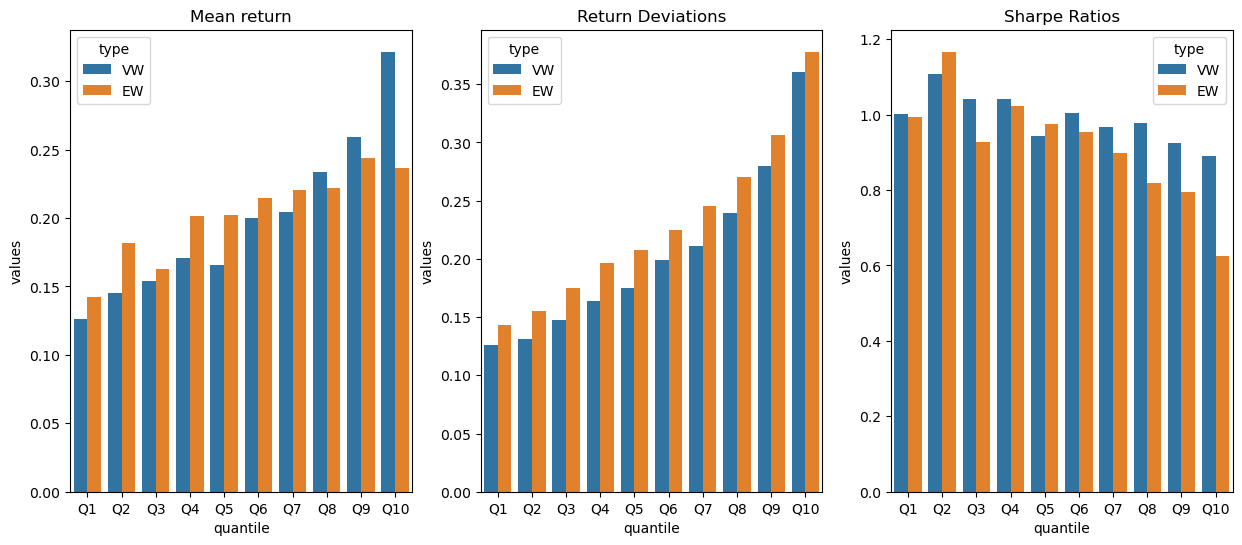

In [7]:
import seaborn as sns
# 5. Plot Means Histogram
fig, axs= plt.subplots(1,3,figsize=(15,6))
sns.barplot(means_df,x='quantile',y='values',hue='type',ax=axs[0])
sns.barplot(stds_df,x='quantile',y='values',hue='type',ax=axs[1])
sns.barplot(srs_df,x='quantile',y='values',hue='type',ax=axs[2])

axs[0].set_title('Mean return')
axs[1].set_title('Return Deviations')
axs[2].set_title('Sharpe Ratios')
plt.show()


## BAB PF Construction

In [8]:
# Weights
df3['z'] = df3.groupby('date')['beta'].transform(lambda x: x.rank())
df3['z_'] = df3['z']-df3.groupby('date')['z'].transform('mean')
df3['k'] = np.abs(df3['z_'])
df3['k'] = 2/df3.groupby('date')['k'].transform('sum')
df3['w_H'] = df3['k'] * df3['z_'] * (df3['z_']>0) 
df3['w_L'] = -df3['k'] * df3['z_'] * (df3['z_']<0)

# Weighted returns and beta
df3['beta_H'] = df3['w_H'] * df3['beta']
df3['beta_L'] = df3['w_L'] * df3['beta']
df3['R_H'] = df3['w_H'] * df3['Rn']
df3['R_L'] = df3['w_L'] * df3['Rn']
df3['R_H_e'] = df3['w_H'] * df3['Rn_e']
df3['R_L_e'] = df3['w_L'] * df3['Rn_e']
BAB = df3.groupby('date')[['R_H','R_L','R_H_e','R_L_e','beta_H','beta_L']].sum().reset_index()
BAB['BAB2'] = BAB['R_L_e']/BAB['beta_L'] - BAB['R_H_e']/BAB['beta_H']


In [9]:
# Merge Market and Risk free Rate
tmp = pd.merge(BAB,df3[['date','Rm_e']].drop_duplicates(), on=['date'], how='left')
tmp['const'] = 1

# Alpha and Beta
import statsmodels.api as sm
tmp = tmp.dropna()
OLS_Reg = sm.OLS(tmp['BAB2'], tmp[['const','Rm_e']]).fit()

Alpha_bab = OLS_Reg.params[0]*12
idio_vol = (tmp['BAB2']-OLS_Reg.predict()).std()*np.sqrt(12)
market_rp = tmp['Rm_e'].mean()*12
market_vol = tmp['Rm_e'].std()*np.sqrt(12)
beta_bab = OLS_Reg.params[1]

print('Annualized Alpha of BAB factor: ', Alpha_bab, OLS_Reg.tvalues[0])
print('Sharpe Ratio of BAB factor: ',tmp['BAB2'].mean()/tmp['BAB2'].std()*np.sqrt(12))
print('Idiosyncatic volatility: ',idio_vol)
print('Beta BAB: ',beta_bab)
print('Market Risk Premium: ',market_rp)
print('Market Volatility: ',market_vol)

Annualized Alpha of BAB factor:  0.0659175335497889 2.6415751409647146
Sharpe Ratio of BAB factor:  0.7526118978162012
Idiosyncatic volatility:  0.111734939469205
Beta BAB:  0.5012054698078118
Market Risk Premium:  0.07872392238908113
Market Volatility:  0.16833715761798662


C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_11748\3891231813.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Alpha_bab = OLS_Reg.params[0]*12
C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_11748\3891231813.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_bab = OLS_Reg.params[1]
C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_11748\3891231813.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print

# **Part 5: Idiosyncratic Volatility**


In [10]:
df5=df.copy()
df5.dropna(subset=['Rn_e','Rm_e'],inplace=True)

In [ ]:
volatilities = {}
window=60
min_periods=36
for permno, group in df5.groupby('permno'):
    rolling = group.set_index('date')[['Rn_e', 'Rm_e']].rolling(window, min_periods=min_periods)
    curr_dict = {}
    for window in rolling:
        X = sm.add_constant(window[['Rm_e']])
        y = window['Rn_e']
        results = sm.OLS(y, X).fit()
        preds = results.predict(X)
        idio_vol = (y - preds).std()*np.sqrt(12)
        date = window.iloc[-1].name
        curr_dict[date] = idio_vol 
    volatilities[permno] = curr_dict

# transform the dictionary into a DataFrame
idio_df = pd.DataFrame(volatilities).T.stack().reset_index().rename(columns={'level_0':'permno', 'level_1':'date', 0:'idio_vol'})
# export the DataFrame to a csv file
idio_df.to_csv('idio_vol.csv', index=False)

In [11]:
df_idio=pd.read_csv('C:\EPFL\master\elec\MA2\Investments\investments\idio_vol.csv')
df_idio['date']=pd.to_datetime(df_idio['date'])
df_idio.head()

,permno,date,idio_vol
0,10001,2010-05-28,8.073456e-17
1,10001,2010-04-30,1.602407e-01
2,10001,2010-03-31,2.125114e-01
3,10001,2010-02-26,1.990379e-01
4,10001,2010-01-29,1.815296e-01


In [12]:
df5=df5.merge(df_idio,on=['date','permno'])
df5['idio_vol'] = df5['idio_vol'].clip(df5['idio_vol'].quantile(0.05), df5['idio_vol'].quantile(0.95))
df5['Rn_f'] = df5.groupby(['permno'])['Rn'].shift(-1)
df5.head()

,permno,date,Rn,shrout,prc,siccd,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,idio_vol,Rn_f
0,10001,2009-12-31,0.162621,4361.0,10.3000,4925,44918.3000,43871.6600,0.000032,0.028475,1,0.162589,0.028443,0.234753,-0.018932
1,10001,2010-01-29,-0.018932,4361.0,10.0600,4925,43871.6600,43646.6324,0.000013,-0.037172,1,-0.018945,-0.037185,0.181530,-0.000656
2,10001,2010-02-26,-0.000656,4361.0,10.0084,4925,43646.6324,44351.3700,0.000061,0.034744,1,-0.000717,0.034683,0.199038,0.020643
3,10001,2010-03-31,0.020643,4361.0,10.1700,4925,44351.3700,69137.3000,0.000112,0.063668,1,0.020531,0.063556,0.212511,0.124385
4,10001,2010-04-30,0.124385,6070.0,11.3900,4925,69137.3000,69209.4000,0.000118,0.020036,1,0.124267,0.019918,0.160241,0.004829


## Decile soting

In [13]:
#Generate Quantiles
df5=df5.dropna(subset=['idio_vol']).copy()
df5['idio_q']=df5.groupby('date')['idio_vol'].transform(lambda x :  pd.qcut(x, 10,labels=False, duplicates='drop'))

#Equal-Weighted pfs
ret_ew = df5.groupby(['date','idio_q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('idio_q')['Rn'].mean()*12
ew_rf_mean=df5.groupby('idio_q')['rf'].mean()*12
ew_ret_std = ret_ew.groupby('idio_q')['Rn'].std()*(np.sqrt(12))
ew_sr=(ew_ret_mean-ew_rf_mean)/(ew_ret_std)


# Value-weighed pfs
df5['vw_Q']=df5['mcap']/(df5.groupby(['date','idio_q'])['mcap'].transform('sum'))
df5['ret_vw'] = df5['vw_Q']*df5['Rn']

ret_vw = df5.groupby(['date','idio_q'])['ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('idio_q')['ret_vw'].mean()*12
vw_rf_mean = df5.groupby('idio_q')['rf'].mean()*12
vw_ret_std = ret_vw.groupby('idio_q')['ret_vw'].std()*(np.sqrt(12))
vw_sr=(vw_ret_mean)/(vw_ret_std)

df5.head()

,permno,date,Rn,shrout,prc,siccd,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,idio_vol,Rn_f,idio_q,vw_Q,ret_vw
0,10001,2009-12-31,0.162621,4361.0,10.3000,4925,44918.3000,43871.6600,0.000032,0.028475,1,0.162589,0.028443,0.234753,-0.018932,3,0.000058,9.418648e-06
1,10001,2010-01-29,-0.018932,4361.0,10.0600,4925,43871.6600,43646.6324,0.000013,-0.037172,1,-0.018945,-0.037185,0.181530,-0.000656,1,0.000022,-4.225192e-07
2,10001,2010-02-26,-0.000656,4361.0,10.0084,4925,43646.6324,44351.3700,0.000061,0.034744,1,-0.000717,0.034683,0.199038,0.020643,2,0.000030,-1.993227e-08
3,10001,2010-03-31,0.020643,4361.0,10.1700,4925,44351.3700,69137.3000,0.000112,0.063668,1,0.020531,0.063556,0.212511,0.124385,2,0.000034,7.063250e-07
4,10001,2010-04-30,0.124385,6070.0,11.3900,4925,69137.3000,69209.4000,0.000118,0.020036,1,0.124267,0.019918,0.160241,0.004829,1,0.000034,4.252436e-06


In [14]:
#Constuct dataframes for efficient plotting 
deciles=['Q'+ str(x) for x in np.arange(1,11)]
means=np.concatenate((vw_ret_mean.values,ew_ret_mean.values))
means_df=pd.DataFrame(zip(means,['VW']*len(vw_ret_mean.values)+['EW']*len(ew_ret_mean.values),deciles+deciles),columns=['values','type','quantile'])
stds=np.concatenate((vw_ret_std.values,ew_ret_std.values))
stds_df=pd.DataFrame(zip(stds,['VW']*len(vw_ret_mean.values)+['EW']*len(ew_ret_mean.values),deciles+deciles),columns=['values','type','quantile'])
srs=np.concatenate((vw_sr.values,ew_sr.values))
srs_df=pd.DataFrame(zip(srs,['VW']*len(vw_sr.values)+['EW']*len(ew_sr.values),deciles+deciles),columns=['values','type','quantile'])


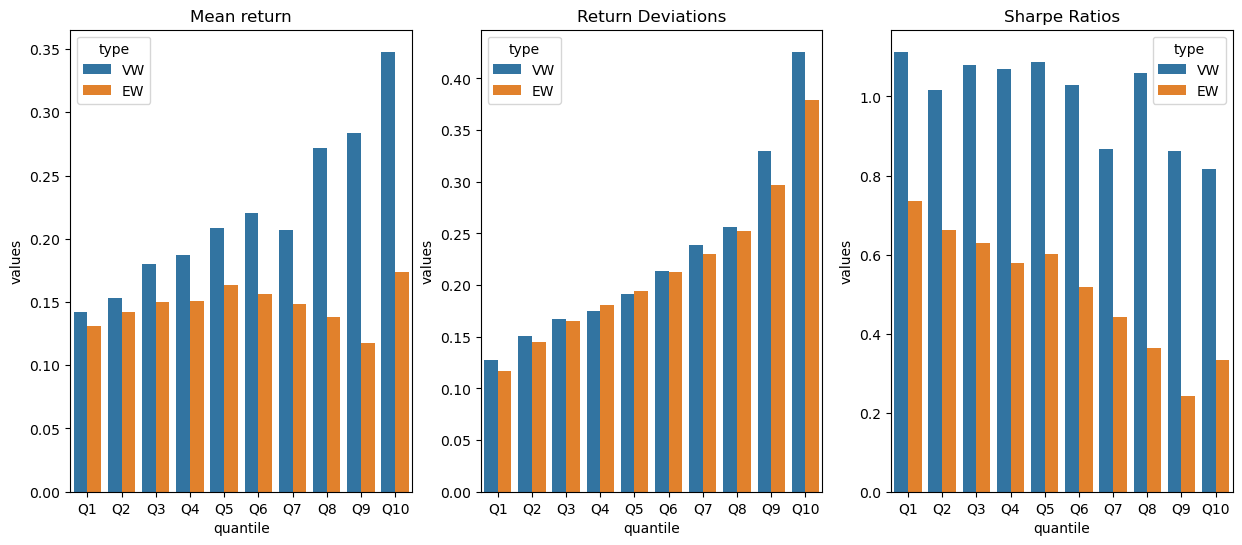

In [15]:
import seaborn as sns
# 5. Plot Means Histogram
fig, axs= plt.subplots(1,3,figsize=(15,6))
sns.barplot(means_df,x='quantile',y='values',hue='type',ax=axs[0])
sns.barplot(stds_df,x='quantile',y='values',hue='type',ax=axs[1])
sns.barplot(srs_df,x='quantile',y='values',hue='type',ax=axs[2])

axs[0].set_title('Mean return')
axs[1].set_title('Return Deviations')
axs[2].set_title('Sharpe Ratios')
plt.show()



## Constructing Volatility portfolio

In [16]:
##Construct three dataframes, one for the strategy and one for the higher deciels and lower decile portfolios
df_deciles=df5[df5['idio_q'].isin([0,1,2,7,8,9])].copy()
df_h=df_deciles[df_deciles['idio_q'].isin([7,8,9])]
df_l=df_deciles[df_deciles['idio_q'].isin([0,1,2])]

Equal weighted strategy

In [17]:
## Short the 3 lowest decile returns to apply the strategy
df_deciles['Rn']=df_deciles.apply(lambda row: (-1)*row['Rn'] if row['idio_q'] in [0,1, 2] else row['Rn'], axis=1)

In [18]:
## PRINTING THE PROPERTIES OF THE DIFFERENT STRATEGIES
mean_h=df_h['Rn'].mean()*12
mean_l=df_l['Rn'].mean()*12
mean_strat=df_deciles['Rn'].mean()*12

std_h=df_h['Rn'].std()*(np.sqrt(12))
std_l=df_l['Rn'].std()*(np.sqrt(12))
std_strat=df_deciles['Rn'].std()*(np.sqrt(12))

sr_h=(mean_h-df_h['rf'].mean())/(std_h)
sr_l=(mean_l-df_l['rf'].mean())/(std_l)
sr_strat=(mean_strat)/(std_strat)


print('-----Annual Return Means-----')
print(f'High Deciles: {mean_h}, Low Deciles: {mean_l}, Strategy: {mean_strat}')
print('-----Annual Return Deviations-----')
print(f'High Deciles: {std_h}, Low Deciles: {std_l}, Strategy: {std_strat}')
print('-----Sharpe Ratios-----')
print(f'High Deciles: {sr_h}, Low Deciles: {sr_l}, Strategy: {sr_strat}')



-----Annual Return Means-----
High Deciles: 0.1311663026506812, Low Deciles: 0.1394767771257518, Strategy: -0.007679182874185329
-----Annual Return Deviations-----
High Deciles: 0.7587824156208495, Low Deciles: 0.2782079293938284, Strategy: 0.5671075065973974
-----Sharpe Ratios-----
High Deciles: 0.1677681272355872, Low Deciles: 0.4876418261180054, Strategy: -0.013540964957878713


In [19]:
## Statistical testing for pvalues
from scipy.stats import ttest_ind
_, pval=ttest_ind(df_deciles.groupby('date')['Rn'].mean()*12,0)
print(pval)

0.9822501277241381


The test's p-value is above 5%, we can conclude that the returns or our long short strategy are not statistically different that 0.

In [20]:
df_deciles['w_L'] = (df_deciles['idio_q'].isin([7,8,9]))*df_deciles['mcap']
df_deciles['w_S'] = (df_deciles['idio_q'].isin([0,1,2]))*df_deciles['mcap']
#Normalize the weights
df_deciles['w_L'] = df_deciles['w_L']/df_deciles.groupby(['date'])['w_L'].transform('sum')
df_deciles['w_S'] = df_deciles['w_S']/df_deciles.groupby(['date'])['w_S'].transform('sum')
df_deciles['w_iv'] = df_deciles['w_L'] - df_deciles['w_S']
idio = df_deciles.groupby('date').apply(lambda x: np.sum(x['Rn_f']*x['w_iv'])).reset_index()
idio['date'] =  idio['date'] + pd.DateOffset(months=1)
idio.columns = ['date','idio_ret']

df_deciles.head()

C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_11748\3928074879.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  idio = df_deciles.groupby('date').apply(lambda x: np.sum(x['Rn_f']*x['w_iv'])).reset_index()


,permno,date,Rn,shrout,prc,siccd,mcap,mcap_l,rf,Rm,...,Rn_e,Rm_e,idio_vol,Rn_f,idio_q,vw_Q,ret_vw,w_L,w_S,w_iv
1,10001,2010-01-29,0.018932,4361.0,10.0600,4925,43871.6600,43646.6324,0.000013,-0.037172,...,-0.018945,-0.037185,0.181530,-0.000656,1,0.000022,-4.225192e-07,0.0,0.000007,-0.000007
2,10001,2010-02-26,0.000656,4361.0,10.0084,4925,43646.6324,44351.3700,0.000061,0.034744,...,-0.000717,0.034683,0.199038,0.020643,2,0.000030,-1.993227e-08,0.0,0.000007,-0.000007
3,10001,2010-03-31,-0.020643,4361.0,10.1700,4925,44351.3700,69137.3000,0.000112,0.063668,...,0.020531,0.063556,0.212511,0.124385,2,0.000034,7.063250e-07,0.0,0.000006,-0.000006
4,10001,2010-04-30,-0.124385,6070.0,11.3900,4925,69137.3000,69209.4000,0.000118,0.020036,...,0.124267,0.019918,0.160241,0.004829,1,0.000034,4.252436e-06,0.0,0.000010,-0.000010
5,10001,2010-05-28,-0.004829,6071.0,11.4000,4925,69209.4000,66028.8000,0.000114,-0.079240,...,0.004715,-0.079354,0.149543,0.083333,0,0.000022,1.083125e-07,0.0,0.000011,-0.000011


In [21]:
idio.head()

,date,idio_ret
0,1964-02-29,0.019535
1,1964-03-28,0.009454
2,1964-04-30,0.034065
3,1964-05-30,-0.004630
4,1964-06-28,-0.024973


In [22]:
print('Idio Return Annualized: ', (idio['idio_ret'].mean()*12))
print('Idio Std Annualized: ',idio['idio_ret'].std()*np.sqrt(12))
print('Idio Sharpe: ',idio['idio_ret'].mean()/idio['idio_ret'].std()*np.sqrt(12))

Idio Return Annualized:  -0.06376288667567317
Idio Std Annualized:  0.187291111227286
Idio Sharpe:  -0.34044801303086997


In [23]:
df_deciles['Low_ret'] = df_deciles['Rn_f'] * df_deciles['w_S']

Low_ret = df_deciles.groupby('date').apply(lambda x: np.sum(x['Low_ret'])).reset_index()
Low_ret_mean = Low_ret[0].mean()* 12
Low_ret_std = Low_ret[0].std()* np.sqrt(12)
Low_SR = Low_ret_mean / Low_ret_std 

print('Mean of Lower quantile factors:', Low_ret_mean )
print('Volatility of Lower quantile factors:', Low_ret_std )
print('Sharpe Ratio of Lower quantile factors:', Low_SR)

Mean of Lower quantile factors: 0.11366828726570635
Volatility of Lower quantile factors: 0.13737110660577115
Sharpe Ratio of Lower quantile factors: 0.827454113709025


C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_11748\182801058.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Low_ret = df_deciles.groupby('date').apply(lambda x: np.sum(x['Low_ret'])).reset_index()


In [24]:
df_deciles['High_ret'] = df_deciles['Rn_f'] * df_deciles['w_L']

High_ret = df_deciles.groupby('date').apply(lambda x: np.sum(x['High_ret'])).reset_index()
High_ret_mean = High_ret[0].mean()*12
High_ret_std = High_ret[0].std()* np.sqrt(12)
High_SR = High_ret_mean / High_ret_std 

print('Mean of Higher quantile factors:', High_ret_mean )
print('Volatility of Higher quantile factors:', High_ret_std )
print('Sharpe Ratio of Higher quantile factors:', High_SR)

Mean of Higher quantile factors: 0.05008886720145172
Volatility of Higher quantile factors: 0.26395787877024934
Sharpe Ratio of Higher quantile factors: 0.18976083394369672


C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_11748\2158263765.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  High_ret = df_deciles.groupby('date').apply(lambda x: np.sum(x['High_ret'])).reset_index()


In [25]:
idio.isna().sum()

date        0
idio_ret    0
dtype: int64

In [26]:
idio.head()

,date,idio_ret
0,1964-02-29,0.019535
1,1964-03-28,0.009454
2,1964-04-30,0.034065
3,1964-05-30,-0.004630
4,1964-06-28,-0.024973


In [27]:
idio.dropna(subset='idio_ret',inplace=True)
_, pval=ttest_ind(idio.groupby('date').mean()*12,0)
print(pval)

[0.92179247]


The test's p-value is above 5%, we can conclude that the returns or our long short strategy are not statistically different that 0.

# **PART 4: Momentum Protfolio**

In [28]:
df=pd.read_csv('C:\EPFL\master\elec\MA2\Investments\investments\data.csv',sep=';')
df['date'] = pd.to_datetime(df['date'])
df.head()

,permno,date,Rn,shrout,prc,siccd,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e
0,10001,2009-12-31,0.162621,4361.0,10.3000,4925,44918.3000,43871.6600,0.000032,0.028475,1,0.162589,0.028443
1,10001,2010-01-29,-0.018932,4361.0,10.0600,4925,43871.6600,43646.6324,0.000013,-0.037172,1,-0.018945,-0.037185
2,10001,2010-02-26,-0.000656,4361.0,10.0084,4925,43646.6324,44351.3700,0.000061,0.034744,1,-0.000717,0.034683
3,10001,2010-03-31,0.020643,4361.0,10.1700,4925,44351.3700,69137.3000,0.000112,0.063668,1,0.020531,0.063556
4,10001,2010-04-30,0.124385,6070.0,11.3900,4925,69137.3000,69209.4000,0.000118,0.020036,1,0.124267,0.019918


**MOMENTUM**

In [29]:
#Cumulative 12 month past return for each stock:
df=df.sort_values(['permno','date']).reset_index(drop=True)
df['LN_Cret12'] = df.groupby('permno').apply(lambda x: np.log(x.Rn+1).rolling(11,closed='left').sum()).values
df['Rn_f'] = df.groupby(['permno'])['Rn'].shift(-1)
df.head()

C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_11748\2346461583.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['LN_Cret12'] = df.groupby('permno').apply(lambda x: np.log(x.Rn+1).rolling(11,closed='left').sum()).values


,permno,date,Rn,shrout,prc,siccd,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,LN_Cret12,Rn_f
0,10001,2009-12-31,0.162621,4361.0,10.3000,4925,44918.3000,43871.6600,0.000032,0.028475,1,0.162589,0.028443,NaN,-0.018932
1,10001,2010-01-29,-0.018932,4361.0,10.0600,4925,43871.6600,43646.6324,0.000013,-0.037172,1,-0.018945,-0.037185,NaN,-0.000656
2,10001,2010-02-26,-0.000656,4361.0,10.0084,4925,43646.6324,44351.3700,0.000061,0.034744,1,-0.000717,0.034683,NaN,0.020643
3,10001,2010-03-31,0.020643,4361.0,10.1700,4925,44351.3700,69137.3000,0.000112,0.063668,1,0.020531,0.063556,NaN,0.124385
4,10001,2010-04-30,0.124385,6070.0,11.3900,4925,69137.3000,69209.4000,0.000118,0.020036,1,0.124267,0.019918,NaN,0.004829


In [30]:
df4=df.copy()
df4=df4.dropna(subset='LN_Cret12')
#Momentum decile weights
q = 10
#Momentum is the decile
df4['Momentum'] = df4.groupby('date')['LN_Cret12'].transform(lambda x: pd.qcut(x,q,labels=False, duplicates='drop'))
df4['w_L'] = (df4['Momentum'].isin([7,8,9]))*df4['mcap']
df4['w_S'] = (df4['Momentum'].isin([0,1,2]))*df4['mcap']
#Normalize the weights
df4['w_L'] = df4['w_L']/df4.groupby(['date'])['w_L'].transform('sum')
df4['w_S'] = df4['w_S']/df4.groupby(['date'])['w_S'].transform('sum')
df4['w_Mom'] = df4['w_L'] - df4['w_S']
Momentum = df4.groupby('date').apply(lambda x: np.sum(x['Rn_f']*x['w_Mom'])).reset_index()
Momentum['date'] =  Momentum['date'] + pd.DateOffset(months=1)
Momentum.columns = ['date','Mom_ret']

C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_11748\1109875752.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Momentum = df4.groupby('date').apply(lambda x: np.sum(x['Rn_f']*x['w_Mom'])).reset_index()


In [31]:
print('Momentum Return Annualized: ', (Momentum['Mom_ret'].mean()*12))
print('Momentum Std Annualized: ',Momentum['Mom_ret'].std()*np.sqrt(12))
print('Momentum Sharpe: ',Momentum['Mom_ret'].mean()/Momentum['Mom_ret'].std()*np.sqrt(12))

Momentum Return Annualized:  0.05687681360837094
Momentum Std Annualized:  0.1714724070519233
Momentum Sharpe:  0.33169659530788626


In [32]:
df4['Low_ret'] = df4['Rn_f'] * df4['w_S']

Low_ret = df4.groupby('date').apply(lambda x: np.sum(x['Low_ret'])).reset_index()
Low_ret_mean = Low_ret[0].mean()* 12
Low_ret_std = Low_ret[0].std()* np.sqrt(12)
Low_SR = Low_ret_mean / Low_ret_std 

print('Mean of Lower quantile factors:', Low_ret_mean )
print('Volatility of Lower quantile factors:', Low_ret_std )
print('Sharpe Ratio of Lower quantile factors:', Low_SR)

Mean of Lower quantile factors: 0.07846169681583112
Volatility of Lower quantile factors: 0.22221061457700458
Sharpe Ratio of Lower quantile factors: 0.3530960794343202


C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_11748\936145300.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Low_ret = df4.groupby('date').apply(lambda x: np.sum(x['Low_ret'])).reset_index()


In [33]:
df4['High_ret'] = df4['Rn_f'] * df4['w_L']

High_ret = df4.groupby('date').apply(lambda x: np.sum(x['High_ret'])).reset_index()
High_ret_mean = High_ret[0].mean()*12
High_ret_std = High_ret[0].std()* np.sqrt(12)
High_SR = High_ret_mean / High_ret_std 

print('Mean of Higher quantile factors:', High_ret_mean )
print('Volatility of Higher quantile factors:', High_ret_std )
print('Sharpe Ratio of Higher quantile factors:', High_SR)

Mean of Higher quantile factors: 0.13533851042420206
Volatility of Higher quantile factors: 0.16663296692127325
Sharpe Ratio of Higher quantile factors: 0.8121952871915409


C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_11748\2463537388.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  High_ret = df4.groupby('date').apply(lambda x: np.sum(x['High_ret'])).reset_index()


## Equal and value weighed per quantile

In [34]:
#Generate deciles
df_momentum=df4.dropna(subset=['Momentum']).copy()
df_momentum['momentum_deciles']=df_momentum.groupby('date')['Momentum'].transform(lambda x :  pd.qcut(x, 10,labels=False, duplicates='drop'))

#Equal-Weighted pfs
ret_ew = df_momentum.groupby(['date','momentum_deciles'])['Rn_f'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('momentum_deciles')['Rn_f'].mean()*12
ew_ret_std = ret_ew.groupby('momentum_deciles')['Rn_f'].std()*(np.sqrt(12))
ew_rf_mean=df_momentum.groupby('momentum_deciles')['rf'].mean()*12
ew_sr=(ew_ret_mean)/(ew_ret_std)



# Value-weighed pfs
df_momentum['vw_Q']=df_momentum['mcap']/(df_momentum.groupby(['date','momentum_deciles'])['mcap'].transform('sum'))
df_momentum['ret_vw'] = df_momentum['vw_Q']*df_momentum['Rn_f']
ret_vw = df_momentum.groupby(['date','momentum_deciles'])['ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('momentum_deciles')['ret_vw'].mean()*12
vw_ret_std = ret_vw.groupby('momentum_deciles')['ret_vw'].std()*(np.sqrt(12))
vw_sr=(vw_ret_mean)/(vw_ret_std)

In [35]:
#Constuct dataframes for efficient plotting 
deciles=['Q'+ str(x) for x in np.arange(1,11)]
means=np.concatenate((vw_ret_mean.values,ew_ret_mean.values))
means_df=pd.DataFrame(zip(means,['VW']*len(vw_ret_mean.values)+['EW']*len(ew_ret_mean.values),deciles+deciles),columns=['values','type','quantile'])
stds=np.concatenate((vw_ret_std.values,ew_ret_std.values))
stds_df=pd.DataFrame(zip(stds,['VW']*len(vw_ret_mean.values)+['EW']*len(ew_ret_mean.values),deciles+deciles),columns=['values','type','quantile'])
srs=np.concatenate((vw_sr.values,ew_sr.values))
srs_df=pd.DataFrame(zip(srs,['VW']*len(vw_sr.values)+['EW']*len(ew_sr.values),deciles+deciles),columns=['values','type','quantile'])

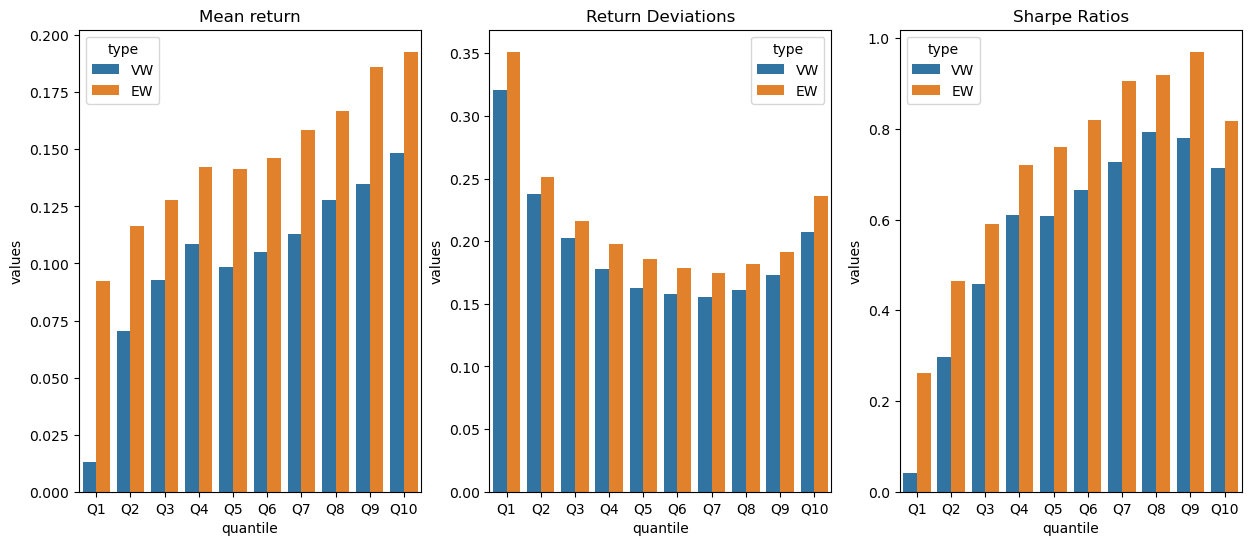

In [36]:
import seaborn as sns
# 5. Plot Means Histogram
fig, axs= plt.subplots(1,3,figsize=(15,6))
sns.barplot(means_df,x='quantile',y='values',hue='type',ax=axs[0])
sns.barplot(stds_df,x='quantile',y='values',hue='type',ax=axs[1])
sns.barplot(srs_df,x='quantile',y='values',hue='type',ax=axs[2])

axs[0].set_title('Mean return')
axs[1].set_title('Return Deviations')
axs[2].set_title('Sharpe Ratios')
plt.show()

In [37]:
# Long leg (deciles 7 to 9)
ew_long_leg = df_momentum[df_momentum['momentum_deciles'] > 6].groupby('date')['Rn'].mean().reset_index()
ew_long_leg.columns = ['date', 'ew_long_leg']

# Short leg (deciles 0 to 2)
ew_short_leg = df_momentum[df_momentum['momentum_deciles'] < 3].groupby('date')['Rn'].mean().reset_index()
ew_short_leg.columns = ['date', 'ew_short_leg']

# Merge long and short legs
ew_legs = pd.merge(ew_long_leg, ew_short_leg, on='date')
ew_legs['ew_strategy'] = ew_legs['ew_long_leg'] - ew_legs['ew_short_leg']

# Compute statistics
ew_means = ew_legs[['ew_long_leg', 'ew_short_leg', 'ew_strategy']].mean() * 12
ew_stds = ew_legs[['ew_long_leg', 'ew_short_leg', 'ew_strategy']].std() * np.sqrt(12)
ew_sharpe_ratios = ew_means / ew_stds

print("Equal-Weighted Portfolios Statistics")
print("Means (Annualized):", ew_means)
print("Standard Deviations (Annualized):", ew_stds)
print("Sharpe Ratios:", ew_sharpe_ratios)

Equal-Weighted Portfolios Statistics
Means (Annualized): ew_long_leg     0.162958
ew_short_leg    0.139045
ew_strategy     0.023913
dtype: float64
Standard Deviations (Annualized): ew_long_leg     0.190562
ew_short_leg    0.277025
ew_strategy     0.183749
dtype: float64
Sharpe Ratios: ew_long_leg     0.855148
ew_short_leg    0.501924
ew_strategy     0.130140
dtype: float64


In [38]:
# Long leg (deciles 7 to 9)
vw_long_leg = df_momentum[df_momentum['momentum_deciles'] > 6].groupby('date').apply(lambda x: np.sum(x['Rn'] * x['vw_Q'])).reset_index()
vw_long_leg.columns = ['date', 'vw_long_leg']

# Short leg (deciles 0 to 2)
vw_short_leg = df_momentum[df_momentum['momentum_deciles'] < 3].groupby('date').apply(lambda x: np.sum(x['Rn'] * x['vw_Q'])).reset_index()
vw_short_leg.columns = ['date', 'vw_short_leg']

# Merge long and short legs
vw_legs = pd.merge(vw_long_leg, vw_short_leg, on='date')
vw_legs['vw_strategy'] = vw_legs['vw_long_leg'] - vw_legs['vw_short_leg']

# Compute statistics
vw_means = vw_legs[['vw_long_leg', 'vw_short_leg', 'vw_strategy']].mean() * 12
vw_stds = vw_legs[['vw_long_leg', 'vw_short_leg', 'vw_strategy']].std() * np.sqrt(12)
vw_sharpe_ratios = vw_means / vw_stds

print("Value-Weighted Portfolios Statistics")
print("Means (Annualized):", vw_means)
print("Standard Deviations (Annualized):", vw_stds)
print("Sharpe Ratios:", vw_sharpe_ratios)


C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_11748\1898691597.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vw_long_leg = df_momentum[df_momentum['momentum_deciles'] > 6].groupby('date').apply(lambda x: np.sum(x['Rn'] * x['vw_Q'])).reset_index()


Value-Weighted Portfolios Statistics
Means (Annualized): vw_long_leg     0.579765
vw_short_leg    0.657504
vw_strategy    -0.077738
dtype: float64
Standard Deviations (Annualized): vw_long_leg     0.495102
vw_short_leg    0.789282
vw_strategy     0.649110
dtype: float64
Sharpe Ratios: vw_long_leg     1.171003
vw_short_leg    0.833040
vw_strategy    -0.119761
dtype: float64


C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_11748\1898691597.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vw_short_leg = df_momentum[df_momentum['momentum_deciles'] < 3].groupby('date').apply(lambda x: np.sum(x['Rn'] * x['vw_Q'])).reset_index()


In [39]:
from scipy import stats

ew_ttest = stats.ttest_1samp(ew_legs['ew_strategy'], 0)
print("Equal-Weighted Portfolio Strategy T-Test:", ew_ttest)

vw_ttest = stats.ttest_1samp(vw_legs['vw_strategy'], 0)
print("Value-Weighted Portfolio Strategy T-Test:", vw_ttest)

Equal-Weighted Portfolio Strategy T-Test: TtestResult(statistic=1.0003309901934605, pvalue=0.3174921133855464, df=708)
Value-Weighted Portfolio Strategy T-Test: TtestResult(statistic=-0.9205533991986716, pvalue=0.3575971881300668, df=708)


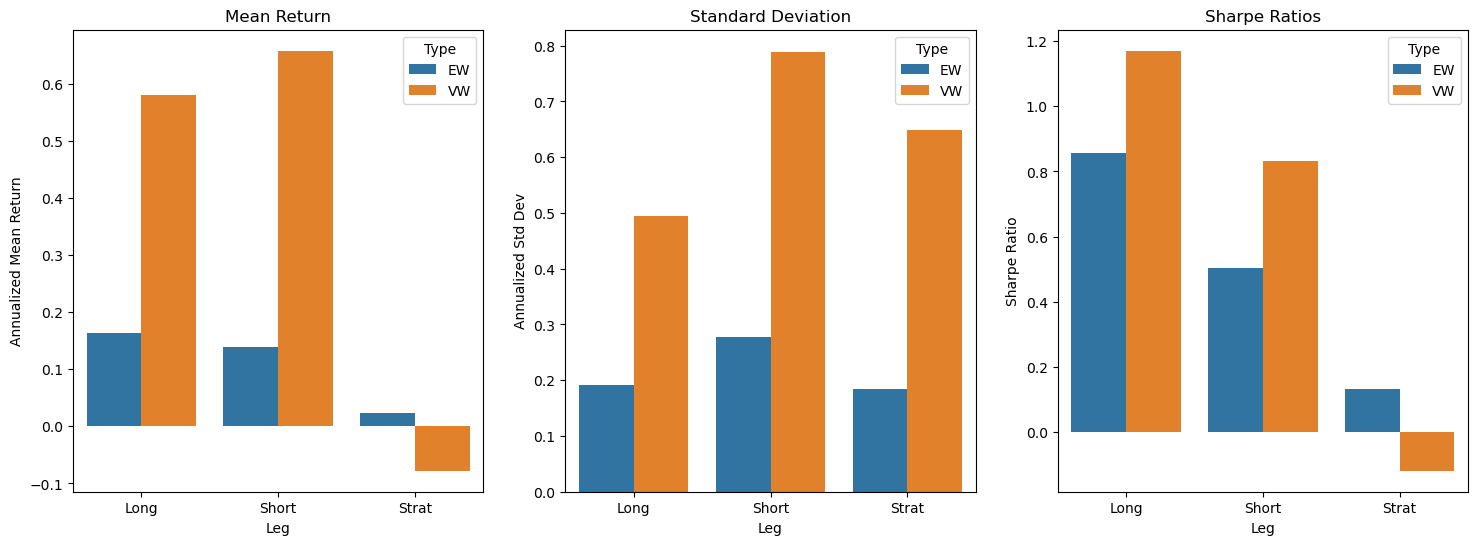

In [40]:
# Prepare data for plotting
ew_means_df = pd.DataFrame(ew_means).reset_index()
ew_means_df.columns = ['Leg', 'Annualized Mean Return']
ew_means_df['Type'] = 'EW'

ew_stds_df = pd.DataFrame(ew_stds).reset_index()
ew_stds_df.columns = ['Leg', 'Annualized Std Dev']
ew_stds_df['Type'] = 'EW'

ew_sharpe_ratios_df = pd.DataFrame(ew_sharpe_ratios).reset_index()
ew_sharpe_ratios_df.columns = ['Leg', 'Sharpe Ratio']
ew_sharpe_ratios_df['Type'] = 'EW'

vw_means_df = pd.DataFrame(vw_means).reset_index()
vw_means_df.columns = ['Leg', 'Annualized Mean Return']
vw_means_df['Type'] = 'VW'

vw_stds_df = pd.DataFrame(vw_stds).reset_index()
vw_stds_df.columns = ['Leg', 'Annualized Std Dev']
vw_stds_df['Type'] = 'VW'

vw_sharpe_ratios_df = pd.DataFrame(vw_sharpe_ratios).reset_index()
vw_sharpe_ratios_df.columns = ['Leg', 'Sharpe Ratio']
vw_sharpe_ratios_df['Type'] = 'VW'

combined_means_df = pd.concat([ew_means_df, vw_means_df])
combined_stds_df = pd.concat([ew_stds_df, vw_stds_df])
combined_sharpe_ratios_df = pd.concat([ew_sharpe_ratios_df, vw_sharpe_ratios_df])

# Update the names for clarity
ew_means_df['Leg'] = ew_means_df['Leg'].replace({'ew_long_leg': 'Long', 'ew_short_leg': 'Short', 'ew_strategy': 'Strat'})
ew_stds_df['Leg'] = ew_stds_df['Leg'].replace({'ew_long_leg': 'Long', 'ew_short_leg': 'Short', 'ew_strategy': 'Strat'})
ew_sharpe_ratios_df['Leg'] = ew_sharpe_ratios_df['Leg'].replace({'ew_long_leg': 'Long', 'ew_short_leg': 'Short', 'ew_strategy': 'Strat'})

vw_means_df['Leg'] = vw_means_df['Leg'].replace({'vw_long_leg': 'Long', 'vw_short_leg': 'Short', 'vw_strategy': 'Strat'})
vw_stds_df['Leg'] = vw_stds_df['Leg'].replace({'vw_long_leg': 'Long', 'vw_short_leg': 'Short', 'vw_strategy': 'Strat'})
vw_sharpe_ratios_df['Leg'] = vw_sharpe_ratios_df['Leg'].replace({'vw_long_leg': 'Long', 'vw_short_leg': 'Short', 'vw_strategy': 'Strat'})


combined_means_df = pd.concat([ew_means_df, vw_means_df])
combined_stds_df = pd.concat([ew_stds_df, vw_stds_df])
combined_sharpe_ratios_df = pd.concat([ew_sharpe_ratios_df, vw_sharpe_ratios_df])

# Plot combined statistics
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

sns.barplot(x='Leg', y='Annualized Mean Return', hue='Type', data=combined_means_df, ax=axs[0])
sns.barplot(x='Leg', y='Annualized Std Dev', hue='Type', data=combined_stds_df, ax=axs[1])
sns.barplot(x='Leg', y='Sharpe Ratio', hue='Type', data=combined_sharpe_ratios_df, ax=axs[2])

axs[0].set_title('Mean Return')
axs[1].set_title('Standard Deviation')
axs[2].set_title('Sharpe Ratios')

plt.show()

# **PART 6: Optimal Fund Portfolio Return**

In [41]:
target_volatility=0.1

In [66]:
BAB.tail()

,date,R_H,R_L,R_H_e,R_L_e,beta_H,beta_L,BAB2
241,2022-12-30,-0.064989,-0.040263,-0.068315,-0.043589,1.831817,0.660729,-0.028678
242,2023-02-28,-0.030739,-0.018768,-0.034421,-0.022450,1.844217,0.662717,-0.015212
243,2023-06-30,0.131553,0.051422,0.127251,0.047120,1.844242,0.659699,0.002427
244,2023-08-31,-0.056823,-0.026595,-0.061287,-0.031059,1.849216,0.659212,-0.013973
245,2023-11-30,0.079071,0.056265,0.074616,0.051810,1.843283,0.663983,0.037549


In [67]:
idio.tail()

,date,idio_ret
714,2023-09-30,-0.014549
715,2023-10-29,-0.037301
716,2023-11-30,0.004682
717,2023-12-30,0.058402
718,2024-01-29,0.000000


In [70]:
r_strat

,date,ret_bab,ret_mom,ret_iv,ret_ew,volatility_bab,volatility_mom,volatility_iv,total_vol,w_bab,w_mom,w_iv,ret_rp,rf,ret_mve
0,1967-02-28,0.017142,0.033823,0.071655,0.040873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003737,0.040621
1,1967-06-30,-0.009270,0.052693,0.136827,0.060083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003089,0.060091
2,1967-08-31,0.016245,-0.007982,0.050218,0.019494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003216,0.017964
3,1967-11-30,0.004044,0.008321,0.000000,0.004122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003491,0.004359
4,1968-02-29,-0.021301,-0.043432,-0.072830,-0.045854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003894,-0.045868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,2022-12-30,-0.028678,0.045025,-0.045463,-0.009706,0.030110,0.045817,0.047655,76.021426,0.436867,0.287104,0.276029,-0.012151,0.003326,-0.006502
242,2023-02-28,-0.015212,0.000718,0.008552,-0.001981,0.030265,0.045335,0.046474,76.617023,0.431256,0.287899,0.280845,-0.003952,0.003682,-0.001747
243,2023-06-30,0.002427,0.002319,0.046051,0.016932,0.030210,0.044810,0.046383,76.977968,0.430017,0.289910,0.280073,0.014614,0.004302,0.016197
244,2023-08-31,-0.013973,0.051355,-0.045913,-0.002844,0.030219,0.045297,0.046693,76.584994,0.432095,0.288260,0.279645,-0.004073,0.004463,0.000282


In [44]:
r_bab=BAB.copy()
r_mom=Momentum.groupby('date')['Mom_ret'].sum().copy()
r_iv=idio.groupby('date')['idio_ret'].sum().copy()

In [45]:
r_strat=r_bab.merge(r_mom,on='date').merge(r_iv,on='date')
r_strat.rename(columns={'BAB2':'ret_bab',	'Mom_ret':'ret_mom',	'idio_ret':'ret_iv'},inplace=True)
r_strat=r_strat[['date','ret_bab', 'ret_mom', 'ret_iv']]
r_strat.head()

,date,ret_bab,ret_mom,ret_iv
0,1967-02-28,0.017142,0.033823,0.071655
1,1967-06-30,-0.009270,0.052693,0.136827
2,1967-08-31,0.016245,-0.007982,0.050218
3,1967-11-30,0.004044,0.008321,0.000000
4,1968-02-29,-0.021301,-0.043432,-0.072830


## Equal weighed returns

In [46]:
r_strat['ret_ew']= r_strat[['ret_bab', 'ret_mom', 'ret_iv']].mean(axis=1)
r_strat.head()

,date,ret_bab,ret_mom,ret_iv,ret_ew
0,1967-02-28,0.017142,0.033823,0.071655,0.040873
1,1967-06-30,-0.009270,0.052693,0.136827,0.060083
2,1967-08-31,0.016245,-0.007982,0.050218,0.019494
3,1967-11-30,0.004044,0.008321,0.000000,0.004122
4,1968-02-29,-0.021301,-0.043432,-0.072830,-0.045854


## Risk parity

In [47]:
window_size=60
min_req=36
# Calculate rolling window volatility for each column
r_strat['volatility_bab'] = r_strat['ret_bab'].rolling(window=window_size,min_periods=min_req).std()
r_strat['volatility_mom'] = r_strat['ret_mom'].rolling(window=window_size,min_periods=min_req).std()
r_strat['volatility_iv'] = r_strat['ret_iv'].rolling(window=window_size,min_periods=min_req).std()

r_strat['total_vol']=(1/r_strat['volatility_bab'])+ (1/r_strat['volatility_mom' ])+ (1/r_strat['volatility_iv'])

r_strat['w_bab']=(1/r_strat['volatility_bab'])/r_strat['total_vol']    
r_strat['w_mom']=(1/r_strat['volatility_mom' ])/r_strat['total_vol']    
r_strat['w_iv']=(1/r_strat['volatility_iv'])/r_strat['total_vol']

r_strat['ret_rp']=r_strat['ret_bab']*r_strat['w_bab']+r_strat['ret_iv']*r_strat['w_iv']+r_strat['ret_mom']*r_strat['w_mom']
r_strat.to_csv('w_rp.csv')
r_strat.head()

,date,ret_bab,ret_mom,ret_iv,ret_ew,volatility_bab,volatility_mom,volatility_iv,total_vol,w_bab,w_mom,w_iv,ret_rp
0,1967-02-28,0.017142,0.033823,0.071655,0.040873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1967-06-30,-0.009270,0.052693,0.136827,0.060083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1967-08-31,0.016245,-0.007982,0.050218,0.019494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1967-11-30,0.004044,0.008321,0.000000,0.004122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1968-02-29,-0.021301,-0.043432,-0.072830,-0.045854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Setting up risk free rates for the mean variance efficient pf


In [48]:
rf_df=df.groupby('date')['rf'].mean()
r_strat=r_strat.merge(rf_df,on='date',how='left')
r_strat.head()

,date,ret_bab,ret_mom,ret_iv,ret_ew,volatility_bab,volatility_mom,volatility_iv,total_vol,w_bab,w_mom,w_iv,ret_rp,rf
0,1967-02-28,0.017142,0.033823,0.071655,0.040873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003737
1,1967-06-30,-0.009270,0.052693,0.136827,0.060083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003089
2,1967-08-31,0.016245,-0.007982,0.050218,0.019494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003216
3,1967-11-30,0.004044,0.008321,0.000000,0.004122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003491
4,1968-02-29,-0.021301,-0.043432,-0.072830,-0.045854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003894


## Mean Variance efficient

In [49]:
## TODO: add rf rates+ look at ps3 for rolling average and stds
def compute_tangency_w(data):
    rf=data['rf'].mean()
    cov=data[['ret_bab','ret_mom','ret_iv']].cov().values*12
    inv_cov=np.linalg.inv(cov)
    mu=np.array([data['ret_bab'].mean()-rf*12,data['ret_mom'].mean()-rf*12,data['ret_iv'].mean()-rf*12])
    w= (inv_cov @ mu)/(np.ones(3)@inv_cov@mu)
    return w

In [50]:
w=compute_tangency_w(r_strat)

In [51]:
r_strat['ret_mve']=w[0]*r_strat['ret_bab']+w[1]*r_strat['ret_mom']+w[2]*r_strat['ret_iv']
r_strat

,date,ret_bab,ret_mom,ret_iv,ret_ew,volatility_bab,volatility_mom,volatility_iv,total_vol,w_bab,w_mom,w_iv,ret_rp,rf,ret_mve
0,1967-02-28,0.017142,0.033823,0.071655,0.040873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003737,0.040621
1,1967-06-30,-0.009270,0.052693,0.136827,0.060083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003089,0.060091
2,1967-08-31,0.016245,-0.007982,0.050218,0.019494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003216,0.017964
3,1967-11-30,0.004044,0.008321,0.000000,0.004122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003491,0.004359
4,1968-02-29,-0.021301,-0.043432,-0.072830,-0.045854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003894,-0.045868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,2022-12-30,-0.028678,0.045025,-0.045463,-0.009706,0.030110,0.045817,0.047655,76.021426,0.436867,0.287104,0.276029,-0.012151,0.003326,-0.006502
242,2023-02-28,-0.015212,0.000718,0.008552,-0.001981,0.030265,0.045335,0.046474,76.617023,0.431256,0.287899,0.280845,-0.003952,0.003682,-0.001747
243,2023-06-30,0.002427,0.002319,0.046051,0.016932,0.030210,0.044810,0.046383,76.977968,0.430017,0.289910,0.280073,0.014614,0.004302,0.016197
244,2023-08-31,-0.013973,0.051355,-0.045913,-0.002844,0.030219,0.045297,0.046693,76.584994,0.432095,0.288260,0.279645,-0.004073,0.004463,0.000282


## Calculating constants

In [52]:
c_ew=np.sqrt(target_volatility**2/(r_strat['ret_ew'].std()**2))
c_rp=np.sqrt(target_volatility**2/(r_strat['ret_rp'].std()**2))
c_mve=np.sqrt(target_volatility**2/(r_strat['ret_mve'].std()**2))

print(f'Scaling constants EW:{c_ew}, RP:{c_rp}, MVE: {c_mve}')

Scaling constants EW:4.013328530722743, RP:4.114735210774907, MVE: 4.025566061131223


In [53]:
#Constuct dataframes for efficient plotting 
strats=['EW','RP','MVE']
means=[r_strat['ret_ew'].mean(),r_strat['ret_rp'].mean(),r_strat['ret_mve'].mean()]
means_df=pd.DataFrame(zip(means,strats,strats),columns=['values','type','quantile'])
stds=[r_strat['ret_ew'].std(),r_strat['ret_rp'].std(),r_strat['ret_mve'].std()]
stds_df=pd.DataFrame(zip(stds,strats,strats),columns=['values','type','quantile'])
srs=(np.array(means))/np.array(stds)
srs_df=pd.DataFrame(zip(srs,strats,strats),columns=['values','type','quantile'])

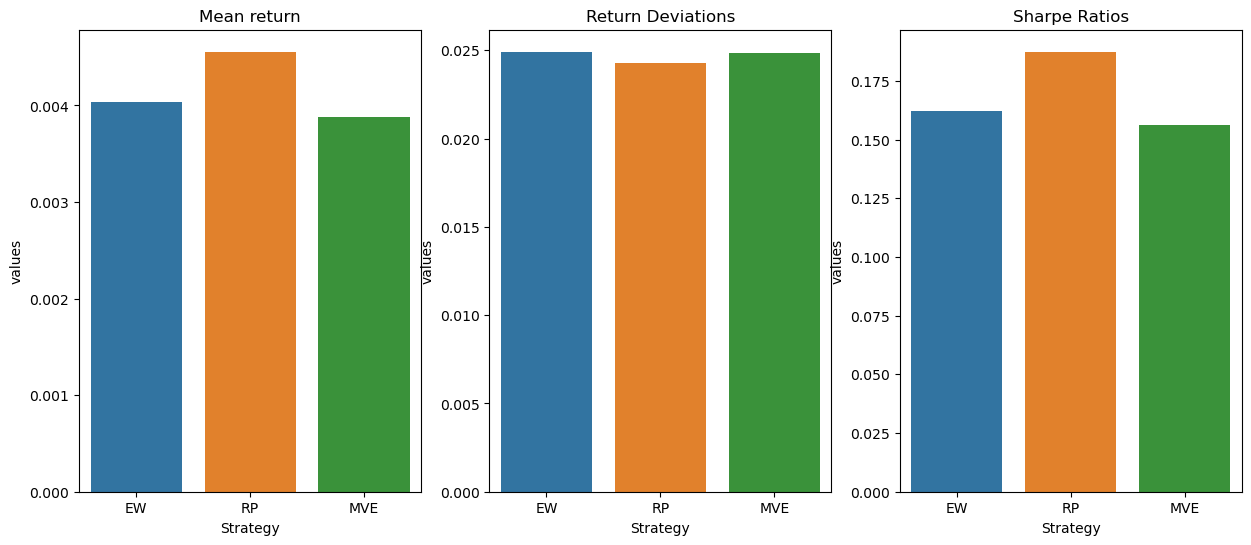

In [54]:
fig, axs= plt.subplots(1,3,figsize=(15,6))
sns.barplot(means_df,x='quantile',y='values',hue='type',ax=axs[0])
sns.barplot(stds_df,x='quantile',y='values',hue='type',ax=axs[1])
sns.barplot(srs_df,x='quantile',y='values',hue='type',ax=axs[2])

axs[0].set_title('Mean return')
axs[1].set_title('Return Deviations')
axs[2].set_title('Sharpe Ratios')

axs[0].set_xlabel('Strategy')
axs[1].set_xlabel('Strategy')
axs[2].set_xlabel('Strategy')
plt.show()

## 7 Performance and risk analysis for the Fund strategy

 Going forward, we pick the approach with the risk-parity

## a)

In [71]:
print(df3.columns.tolist())

['permno', 'date', 'Rn', 'shrout', 'prc', 'siccd', 'mcap', 'mcap_l', 'rf', 'Rm', 'const', 'Rn_e', 'Rm_e', 'N', 'beta', 'beta_q', 'vw_Q', 'ret_vw', 'z', 'z_', 'k', 'w_H', 'w_L', 'beta_H', 'beta_L', 'R_H', 'R_L', 'R_H_e', 'R_L_e']


In [72]:
df7=df3[['permno', 'date', 'Rn', 'shrout','siccd', 'prc', 'mcap', 'mcap_l', 'rf', 'Rm', 'Rn_e', 'Rm_e','const','beta']]
df7.head()

,permno,date,Rn,shrout,siccd,prc,mcap,mcap_l,rf,Rm,Rn_e,Rm_e,const,beta
36,10001,2013-01-31,0.062701,8157.0,4925,9.87,80509.59,81080.58,0.000051,0.054142,0.062650,0.054091,1,0.464682
37,10001,2013-02-28,0.011651,8157.0,4925,9.94,81080.58,83201.40,0.000040,0.008282,0.011611,0.008242,1,0.484416
38,10001,2013-03-28,0.030684,8157.0,4925,10.20,83201.40,86668.70,0.000034,0.035295,0.030650,0.035261,1,0.484182
44,10001,2013-09-30,0.004412,10372.0,4925,10.20,105794.40,103408.84,0.000017,0.037497,0.004395,0.037480,1,0.479719
48,10001,2014-01-31,0.147572,10452.0,4925,9.17,95844.84,97830.72,0.000042,-0.030020,0.147530,-0.030062,1,0.429576


In [73]:
# Define the date range
start_date = '1964-01-01'
end_date = '2023-12-31'


In [74]:
Strat=r_strat.copy()

In [75]:
Strat

,date,ret_bab,ret_mom,ret_iv,ret_ew,volatility_bab,volatility_mom,volatility_iv,total_vol,w_bab,w_mom,w_iv,ret_rp,rf,ret_mve
0,1967-02-28,0.017142,0.033823,0.071655,0.040873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003737,0.040621
1,1967-06-30,-0.009270,0.052693,0.136827,0.060083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003089,0.060091
2,1967-08-31,0.016245,-0.007982,0.050218,0.019494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003216,0.017964
3,1967-11-30,0.004044,0.008321,0.000000,0.004122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003491,0.004359
4,1968-02-29,-0.021301,-0.043432,-0.072830,-0.045854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003894,-0.045868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,2022-12-30,-0.028678,0.045025,-0.045463,-0.009706,0.030110,0.045817,0.047655,76.021426,0.436867,0.287104,0.276029,-0.012151,0.003326,-0.006502
242,2023-02-28,-0.015212,0.000718,0.008552,-0.001981,0.030265,0.045335,0.046474,76.617023,0.431256,0.287899,0.280845,-0.003952,0.003682,-0.001747
243,2023-06-30,0.002427,0.002319,0.046051,0.016932,0.030210,0.044810,0.046383,76.977968,0.430017,0.289910,0.280073,0.014614,0.004302,0.016197
244,2023-08-31,-0.013973,0.051355,-0.045913,-0.002844,0.030219,0.045297,0.046693,76.584994,0.432095,0.288260,0.279645,-0.004073,0.004463,0.000282


In [76]:
Industry_Returns = pd.read_csv('12_Industry_Portfolios.CSV',index_col='date')
Industry_Returns = Industry_Returns[(Industry_Returns.index >= start_date) & (Industry_Returns.index <= end_date)]
Industry_Returns.index = pd.to_datetime(Industry_Returns.index, format='%Y%m', errors='coerce')+pd.offsets.MonthEnd(0)
Industry_Returns.head()

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
date,,,,,,,,,,,,
1964-01-31,0.8,1.22,2.49,4.85,3.1,2.99,3.32,1.4,2.52,3.7,-1.18,2.77
1964-02-29,1.86,1.64,3.11,1.08,1.98,1.91,-0.28,0.87,1.63,1.65,3.85,6.37
1964-03-31,3.08,1.08,4.22,1.4,2.61,3.42,-0.9,-0.74,2.43,-1.94,0.68,3.39
1964-04-30,-0.47,1.8,-1.79,4.04,-1.48,-3.79,0.83,1.05,2.88,-1.42,-1.02,1.1
1964-05-31,1.56,1.52,1.58,2.15,2.09,2.83,-0.39,0.84,3.91,0.52,-0.03,3.85


In [77]:
# Get the list of all the SIC codes
with open('Siccodes12.txt', 'r') as file:
    lines = file.readlines()

dic = {}

for j in range(0, 10000):
    dic[j] = 12
    sic = lines[0].strip().split(" ")[0]
    i = 1
    while i < len(lines)-2:
        if lines[i].strip() == "":
            sic = lines[i+1].strip().split(" ")[0]
            i += 2
            continue
        else:
            a = lines[i].strip().split("-")
            if j in range(int(a[0]), int(a[1])+1):
                dic[j] = sic
            i += 1

df_ind = pd.DataFrame(dic.items(), columns=['SIC', 'FF_12'])

df_ind.to_csv('48_Industries.csv', index=False)

In [78]:
df_ind.head()

,SIC,FF_12
0,0,12
1,1,12
2,2,12
3,3,12
4,4,12


In [79]:
#---------------------------------------------
# Industry Definitions  and Returns 
#---------------------------------------------

Industry_Definitions = pd.read_csv('48_Industries.CSV')
Industry_Definitions.rename(columns={'SIC':'siccd'},inplace=True)
Industries = Industry_Returns.columns.tolist()
num_industries = len(Industries)
Industry_Names = pd.DataFrame(Industries, index=np.arange(1,13)).reset_index() #num_industries+1
Industry_Names.columns=['Industry','Name']

In [80]:
Industries

['NoDur',
 'Durbl',
 'Manuf',
 'Enrgy',
 'Chems',
 'BusEq',
 'Telcm',
 'Utils',
 'Shops',
 'Hlth ',
 'Money',
 'Other']

In [81]:
Industry_Returns.head()

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
date,,,,,,,,,,,,
1964-01-31,0.8,1.22,2.49,4.85,3.1,2.99,3.32,1.4,2.52,3.7,-1.18,2.77
1964-02-29,1.86,1.64,3.11,1.08,1.98,1.91,-0.28,0.87,1.63,1.65,3.85,6.37
1964-03-31,3.08,1.08,4.22,1.4,2.61,3.42,-0.9,-0.74,2.43,-1.94,0.68,3.39
1964-04-30,-0.47,1.8,-1.79,4.04,-1.48,-3.79,0.83,1.05,2.88,-1.42,-1.02,1.1
1964-05-31,1.56,1.52,1.58,2.15,2.09,2.83,-0.39,0.84,3.91,0.52,-0.03,3.85


In [82]:
df7=pd.merge(df7,Industry_Definitions[['siccd','FF_12']],on=['siccd'], how='left')

In [83]:
df7.head()

,permno,date,Rn,shrout,siccd,prc,mcap,mcap_l,rf,Rm,Rn_e,Rm_e,const,beta,FF_12
0,10001,2013-01-31,0.062701,8157.0,4925,9.87,80509.59,81080.58,0.000051,0.054142,0.062650,0.054091,1,0.464682,8
1,10001,2013-02-28,0.011651,8157.0,4925,9.94,81080.58,83201.40,0.000040,0.008282,0.011611,0.008242,1,0.484416,8
2,10001,2013-03-28,0.030684,8157.0,4925,10.20,83201.40,86668.70,0.000034,0.035295,0.030650,0.035261,1,0.484182,8
3,10001,2013-09-30,0.004412,10372.0,4925,10.20,105794.40,103408.84,0.000017,0.037497,0.004395,0.037480,1,0.479719,8
4,10001,2014-01-31,0.147572,10452.0,4925,9.17,95844.84,97830.72,0.000042,-0.030020,0.147530,-0.030062,1,0.429576,8


In [84]:
df7 = pd.merge(df7, Industry_Returns,on=['date'], how='left')

# Convert the relevant columns to numeric, coercing errors
for industry in Industries:
    df7[industry] = pd.to_numeric(df7[industry], errors='coerce')

# Convert rf to a numpy array
rf_array = np.array(df7['rf'])

# Perform the arithmetic operation
df7[Industries] = df7[Industries] / 100 - rf_array[:, np.newaxis]



In [85]:
df7.head()

,permno,date,Rn,shrout,siccd,prc,mcap,mcap_l,rf,Rm,...,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
0,10001,2013-01-31,0.062701,8157.0,4925,9.87,80509.59,81080.58,0.000051,0.054142,...,0.056349,0.074649,0.067949,0.023549,0.048449,0.050449,0.055749,0.080749,0.062349,0.076449
1,10001,2013-01-31,0.062701,8157.0,4925,9.87,80509.59,81080.58,0.000051,0.054142,...,0.070749,0.066149,0.090349,0.064449,0.085249,0.051049,0.061349,0.090949,0.081949,0.067649
2,10001,2013-02-28,0.011651,8157.0,4925,9.94,81080.58,83201.40,0.000040,0.008282,...,0.012860,0.006760,0.012660,0.006660,0.022860,0.021960,0.008460,0.013160,0.011760,0.017760
3,10001,2013-02-28,0.011651,8157.0,4925,9.94,81080.58,83201.40,0.000040,0.008282,...,0.011060,-0.017340,0.003160,0.012660,-0.014940,0.021960,0.008960,-0.003440,0.025460,0.012560
4,10001,2013-03-28,0.030684,8157.0,4925,10.20,83201.40,86668.70,0.000034,0.035295,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
FF5=pd.read_csv('F-F_5_Factors.csv')
FF5['date'] = pd.to_datetime(FF5['date'], format='%Y%m', errors='coerce')+pd.offsets.MonthEnd(0)
# Filter the data to include only the dates within the specified range
FF5 = FF5[(FF5['date'] >= start_date) & (FF5['date'] <= end_date)]
# Display the first few rows of the filtered data
FF5.head()

,date,Mkt-RF,SMB,HML,RMW,CMA,RF
6,1964-01-31,2.24,0.13,1.48,0.17,1.47,0.30
7,1964-02-29,1.54,0.28,2.81,-0.05,0.91,0.26
8,1964-03-31,1.41,1.23,3.40,-2.21,3.22,0.31
9,1964-04-30,0.10,-1.52,-0.67,-1.27,-1.08,0.29
10,1964-05-31,1.42,-0.63,1.86,-0.16,0.17,0.26


In [87]:
df7 = pd.merge(df7, FF5,on=['date'], how='left')
Fama_French = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
# Convert the relevant columns to numeric, coercing errors
for factor in Fama_French:
    df7[factor] = pd.to_numeric(df7[factor], errors='coerce')

# Perform the arithmetic operation
df7[Fama_French] = df7[Fama_French] / 100 

df7.head()

,permno,date,Rn,shrout,siccd,prc,mcap,mcap_l,rf,Rm,...,Shops,Hlth,Money,Other,Mkt-RF,SMB,HML,RMW,CMA,RF
0,10001,2013-01-31,0.062701,8157.0,4925,9.87,80509.59,81080.58,0.000051,0.054142,...,0.055749,0.080749,0.062349,0.076449,0.0557,0.0048,0.0096,-0.0193,0.0141,0.0
1,10001,2013-01-31,0.062701,8157.0,4925,9.87,80509.59,81080.58,0.000051,0.054142,...,0.061349,0.090949,0.081949,0.067649,0.0557,0.0048,0.0096,-0.0193,0.0141,0.0
2,10001,2013-02-28,0.011651,8157.0,4925,9.94,81080.58,83201.40,0.000040,0.008282,...,0.008460,0.013160,0.011760,0.017760,0.0129,-0.0025,0.0011,-0.0067,0.0052,0.0
3,10001,2013-02-28,0.011651,8157.0,4925,9.94,81080.58,83201.40,0.000040,0.008282,...,0.008960,-0.003440,0.025460,0.012560,0.0129,-0.0025,0.0011,-0.0067,0.0052,0.0
4,10001,2013-03-28,0.030684,8157.0,4925,10.20,83201.40,86668.70,0.000034,0.035295,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
# Inspect column names for any issues
print(Industry_Returns.columns)

# Check for leading/trailing whitespaces in column names
Industry_Returns.columns = Industry_Returns.columns.str.strip()

# Re-check column names after stripping whitespace
print(Industry_Returns.columns)

Index(['NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils',
       'Shops', 'Hlth ', 'Money', 'Other'],
      dtype='object')
Index(['NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils',
       'Shops', 'Hlth', 'Money', 'Other'],
      dtype='object')


In [89]:
print(Strat.head())
print(df7.head())

        date   ret_bab   ret_mom    ret_iv    ret_ew  volatility_bab  \
0 1967-02-28  0.017142  0.033823  0.071655  0.040873             NaN   
1 1967-06-30 -0.009270  0.052693  0.136827  0.060083             NaN   
2 1967-08-31  0.016245 -0.007982  0.050218  0.019494             NaN   
3 1967-11-30  0.004044  0.008321  0.000000  0.004122             NaN   
4 1968-02-29 -0.021301 -0.043432 -0.072830 -0.045854             NaN   

   volatility_mom  volatility_iv  total_vol  w_bab  w_mom  w_iv  ret_rp  \
0             NaN            NaN        NaN    NaN    NaN   NaN     NaN   
1             NaN            NaN        NaN    NaN    NaN   NaN     NaN   
2             NaN            NaN        NaN    NaN    NaN   NaN     NaN   
3             NaN            NaN        NaN    NaN    NaN   NaN     NaN   
4             NaN            NaN        NaN    NaN    NaN   NaN     NaN   

         rf   ret_mve  
0  0.003737  0.040621  
1  0.003089  0.060091  
2  0.003216  0.017964  
3  0.003491  0.00435

In [90]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Assuming 'Strat' and 'df7' are already defined and include the necessary data

# Ensure the 'date' columns are in datetime format
Strat['date'] = pd.to_datetime(Strat['date'])
df7['date'] = pd.to_datetime(df7['date'])

# Define the list of industry and Fama-French columns
Industries = ['NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth', 'Money', 'Other']
Fama_French = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

# Strip any leading or trailing spaces from column names
df7.columns = df7.columns.str.strip()
Strat.columns = Strat.columns.str.strip()


if 'date' not in df7.columns:
    raise KeyError("'date' column not found in df7")
if 'date' not in Strat.columns:
    raise KeyError("'date' column not found in Strat")

# Merge the dataframes on 'date'
tmp = pd.merge(Strat, df7[['date'] + Industries + Fama_French].drop_duplicates(), on='date', how='left')

# Add a constant column for the regression
tmp['const'] = 1

# Drop rows with any NaN values
tmp = tmp.dropna()


# Industry Exposure
RegOLS = sm.OLS(tmp['ret_rp'], tmp[['const'] + Industries + Fama_French]).fit()

# Print regression parameters and R-squared value
print(f"Regression parameters:\n{pd.concat([RegOLS.params, RegOLS.tvalues], axis=1)}\n")
print(f'R^2: {RegOLS.rsquared}')


Regression parameters:
               0         1
const  -0.000004 -0.003659
NoDur   0.141117  2.673473
Durbl  -0.084062 -3.606879
Manuf  -0.123140 -2.012818
Enrgy  -0.020335 -1.478618
Chems  -0.058301 -1.205617
BusEq  -0.000432 -0.012426
Telcm  -0.078909 -2.900541
Utils   0.096198  2.857901
Shops  -0.069614 -1.531822
Hlth    0.016883  0.650676
Money  -0.078415 -1.747648
Other   0.260269  4.388422
Mkt-RF  0.275881  4.213392
SMB     0.360521  8.253527
HML    -0.146643 -2.334200
RMW     0.032985  0.630675
CMA     0.129262  1.914922

R^2: 0.5402676538668107


1. significative negative exposure to energy industry
2. durable, non durable,energy, utils  and other are three most significative industry factors
3. mkt excess returns, SMB, HML and RRMW are the most significative factors of fama-french
4. alpha is 0.8% and highly statistacly significative : industry actors explain the strategies expected return
4. R^2 is 86%: industry  and fama_french factors explain more thand three-quarters of the strategy's return

## GPT Analysis

- Market Risk Premium (Mkt-RF) and Size Factor (SMB) are the most critical factors influencing your strategy's returns.

- Among industry factors, Utilities (Utils), Durables (Durbl), and Energy (Enrgy) are the most relevant, with Utilities and Durables having a positive impact and Energy having a negative impact.
- The high R-squared value (
0.8627
0.8627) indicates that the model explains a significant portion of the variance in your strategy's returns, confirming the importance of these factors.

## b)

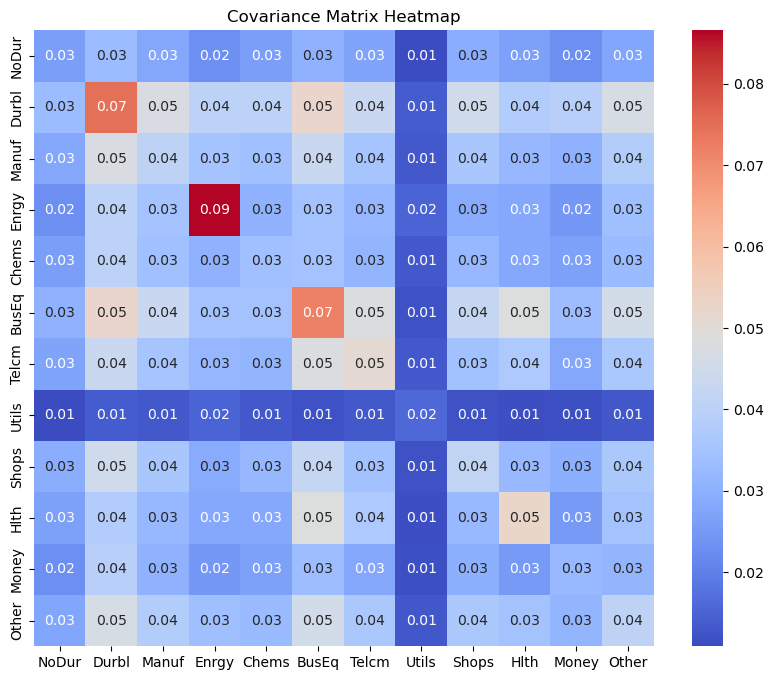

In [91]:
cov_ind=tmp[Industries].cov()*12

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cov_ind, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Covariance Matrix Heatmap')
plt.show()



In [92]:
print(df7.columns.tolist())

['permno', 'date', 'Rn', 'shrout', 'siccd', 'prc', 'mcap', 'mcap_l', 'rf', 'Rm', 'Rn_e', 'Rm_e', 'const', 'beta', 'FF_12', 'NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth', 'Money', 'Other', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']


In [93]:
df7.head()

,permno,date,Rn,shrout,siccd,prc,mcap,mcap_l,rf,Rm,...,Shops,Hlth,Money,Other,Mkt-RF,SMB,HML,RMW,CMA,RF
0,10001,2013-01-31,0.062701,8157.0,4925,9.87,80509.59,81080.58,0.000051,0.054142,...,0.055749,0.080749,0.062349,0.076449,0.0557,0.0048,0.0096,-0.0193,0.0141,0.0
1,10001,2013-01-31,0.062701,8157.0,4925,9.87,80509.59,81080.58,0.000051,0.054142,...,0.061349,0.090949,0.081949,0.067649,0.0557,0.0048,0.0096,-0.0193,0.0141,0.0
2,10001,2013-02-28,0.011651,8157.0,4925,9.94,81080.58,83201.40,0.000040,0.008282,...,0.008460,0.013160,0.011760,0.017760,0.0129,-0.0025,0.0011,-0.0067,0.0052,0.0
3,10001,2013-02-28,0.011651,8157.0,4925,9.94,81080.58,83201.40,0.000040,0.008282,...,0.008960,-0.003440,0.025460,0.012560,0.0129,-0.0025,0.0011,-0.0067,0.0052,0.0
4,10001,2013-03-28,0.030684,8157.0,4925,10.20,83201.40,86668.70,0.000034,0.035295,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
tmp = pd.merge(Strat,df7[['permno', 'date', 'Rn_e', 'beta', 'FF_12']],on=['date'], how='left')
tmp['beta'] = tmp['beta'].clip(-2,2)
# Industry Exposures as Dummy
tmp[Industries] = pd.get_dummies(tmp['FF_12']).replace({True: 1, False: 0})

C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_11748\3914591126.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tmp[Industries] = pd.get_dummies(tmp['FF_12']).replace({True: 1, False: 0})


In [95]:
tmp.head()

,date,ret_bab,ret_mom,ret_iv,ret_ew,volatility_bab,volatility_mom,volatility_iv,total_vol,w_bab,...,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
0,1967-02-28,0.017142,0.033823,0.071655,0.040873,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
1,1967-02-28,0.017142,0.033823,0.071655,0.040873,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
2,1967-02-28,0.017142,0.033823,0.071655,0.040873,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,1967-02-28,0.017142,0.033823,0.071655,0.040873,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,1967-02-28,0.017142,0.033823,0.071655,0.040873,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0


C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_11748\763383898.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Factors = tmp.groupby(['date']).apply(lambda x: sm.OLS(x['Rn_e'],x[['beta']+Industries]).fit().params)
C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_11748\763383898.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Factors_tstats = tmp.groupby(['date']).apply(lambda x: sm.OLS(x['

              0         1
beta   0.056156  5.076009
NoDur  0.659290  3.073668
Durbl  0.431907  2.726227
Manuf  0.910363  3.671094
Enrgy  0.993130  4.606981
Chems  0.551274  2.501978
BusEq  0.826315  3.357053
Telcm  0.358284  1.880215
Utils  0.615686  3.121392
Shops  0.838932  3.495959
Hlth   0.550709  2.737930
Money  0.663108  3.498680
Other  0.765573  3.308082


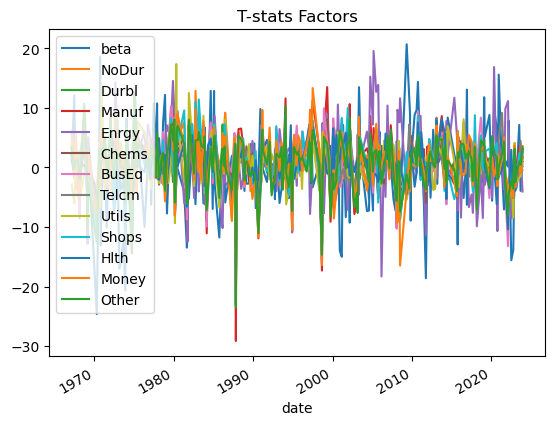

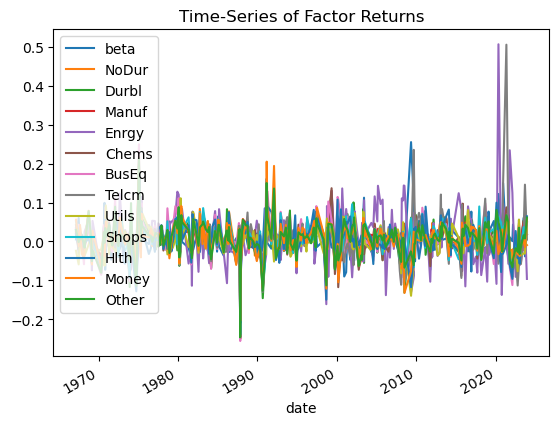

In [96]:
# Estimate Factor

Factors = tmp.groupby(['date']).apply(lambda x: sm.OLS(x['Rn_e'],x[['beta']+Industries]).fit().params)

Factors_tstats = tmp.groupby(['date']).apply(lambda x: sm.OLS(x['Rn_e'],x[['beta']+Industries]).fit().tvalues)

# Plot T-stats
Factors_tstats.plot(),plt.title('T-stats Factors')
Factors.plot(),plt.title('Time-Series of Factor Returns')
print(pd.concat([Factors_tstats.mean(),np.abs(Factors_tstats).mean()],axis=1))

In [97]:
tmp['ret_rp']=tmp['ret_rp']/100

In [98]:
Exposures = tmp[['date','ret_rp','beta'] + Industries].copy()
Exposures[Industries] = Exposures[Industries]*Exposures['ret_rp'].to_numpy()[:,np.newaxis]
Exposures['beta'] = Exposures['ret_rp'] * Exposures['beta']
Exposures = Exposures.groupby('date')[['beta'] + Industries].sum()

In [106]:
Exposures.mean().abs()

beta     0.146417
NoDur    0.014620
Durbl    0.005601
Manuf    0.026996
Enrgy    0.007090
Chems    0.005218
BusEq    0.010335
Telcm    0.002017
Utils    0.009183
Shops    0.015471
Hlth     0.005296
Money    0.015105
Other    0.015713
dtype: float64

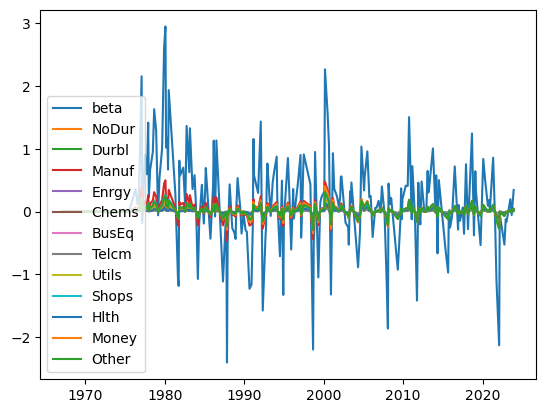

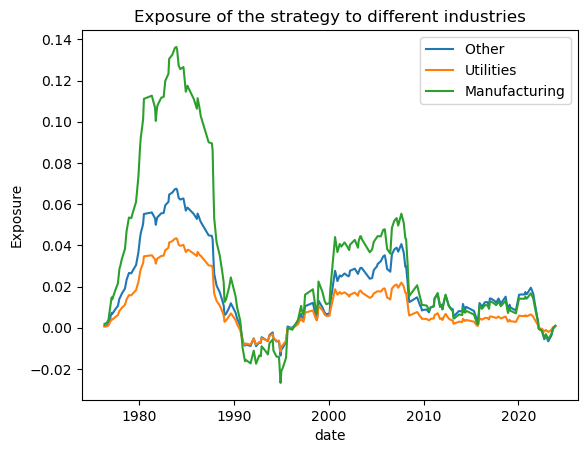

In [105]:
# Plot Exposure to all industries
plt.plot(Exposures)
plt.legend(Exposures.columns)
plt.show()


# Plot Exposure to Tech and Finance
plt.plot(Exposures['Other'].rolling(36).mean())
plt.plot(Exposures['Utils'].rolling(36).mean())
plt.plot(Exposures['Manuf'].rolling(36).mean())
plt.legend(['Other ','Utilities','Manufacturing'])
plt.title('Exposure of the strategy to different industries')
plt.xlabel('date')
plt.ylabel('Exposure')
plt.show()

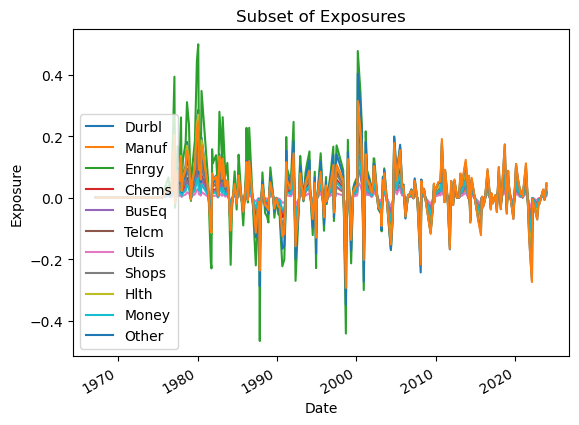

In [101]:
subset_exposures = Exposures.drop(columns=['beta'])
subset_exposures.plot()
plt.xlabel('Date')
plt.ylabel('Exposure')
plt.title('Subset of Exposures')
plt.legend(subset_exposures.columns[1:])
plt.show()

# c)

In [102]:
# Hedge Portfolio Return
Hedge_Return = Factors * Exposures.rename(columns={'beta':'Rm_e'})
Hedge_Return = Hedge_Return.sum(axis=1)

strat_hedge = Strat[['date','ret_rp']].set_index('date')-Hedge_Return.to_numpy()[:,np.newaxis]
print('strategy-Hedged Return: ', strat_hedge.mean()*12)
print('strategy-Hedged Std: ', strat_hedge.std()*np.sqrt(12))
print('strategy-Hedged Sharpe: ', strat_hedge.mean()/strat_hedge.std()*np.sqrt(12))

strategy-Hedged Return:  ret_rp   -0.131705
dtype: float64
strategy-Hedged Std:  ret_rp    0.205832
dtype: float64
strategy-Hedged Sharpe:  ret_rp   -0.639867
dtype: float64
